In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
def load_npy_files(folder_path):
    """
    Loads all .npy files in the given folder and extracts features and labels.
    
    Parameters:
        folder_path (str): Path to the folder containing .npy files.
    
    Returns:
        X (list): List of feature arrays.
        y (list): List of labels.
    """
    X, y = [], []

    for file in os.listdir(folder_path):
        if file.endswith(".npy"):
            # Load the .npy file
            file_path = os.path.join(folder_path, file)
            data = np.load(file_path, allow_pickle=True).item()
            # Append features (MFCC) and label
            X.append([data["mfcc"], data["metadata"]])
            y.append(data["metadata"]["label"])  # Assuming the label is under "label"

    return X, np.array(y)

In [5]:
# Load data
folder_path = "Processed_Stats_ALC"  # Replace with your .npy folder path
X, y = load_npy_files(folder_path)

In [6]:
# Split the data
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Print dataset sizes
print(f"Training set: {len(X_train_full)}, Test set: {len(X_test_full)}")

Training set: 11959, Test set: 2990


In [7]:
# Normalize and preprocess data
X_train = np.array([data_point[0] for data_point in X_train_full]) / np.max([data_point[0] for data_point in X_train_full])
X_test = np.array([data_point[0] for data_point in X_test_full]) / np.max([data_point[0] for data_point in X_test_full])

# Reshape data to match CNN input: (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Ensure labels are integers
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20


/home/dianabacircea/courses/intoxicated-speech-detection/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1733794429.746586   74391 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6710 - loss: 0.6377 - val_accuracy: 0.6829 - val_loss: 0.6187
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6882 - loss: 0.6194 - val_accuracy: 0.6829 - val_loss: 0.6178
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6850 - loss: 0.6162 - val_accuracy: 0.6813 - val_loss: 0.6114
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6890 - loss: 0.6072 - val_accuracy: 0.6849 - val_loss: 0.6131
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6773 - loss: 0.6115 - val_accuracy: 0.6853 - val_loss: 0.6033
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6920 - loss: 0.6024 - val_accuracy: 0.6849 - val_loss: 0.6017
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6884 - loss: 0.6030 - val_accuracy: 0.6883 - val_loss: 0.6001
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6926 - loss: 0.5970 - val_accuracy: 0.6893 - val

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

94/94 - 9s - 91ms/step - accuracy: 0.6890 - loss: 0.6086
Test accuracy: 0.69


In [10]:
# Generate predictions for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [11]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Class 0 (na)", "Class 1 (a)"]))

Classification Report:
              precision    recall  f1-score   support

Class 0 (na)       0.71      0.91      0.80      2042
 Class 1 (a)       0.52      0.22      0.31       948

    accuracy                           0.69      2990
   macro avg       0.62      0.56      0.55      2990
weighted avg       0.65      0.69      0.64      2990



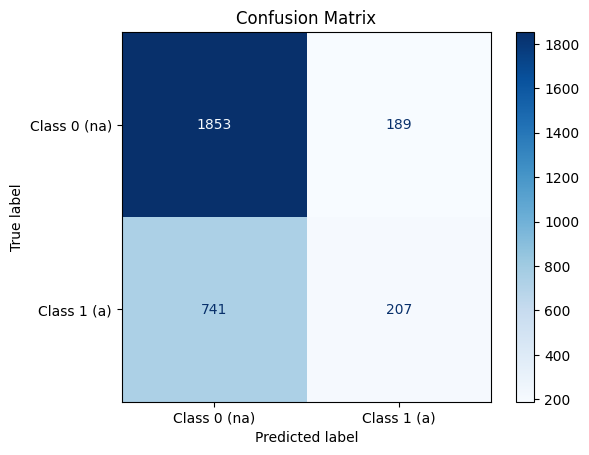

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0 (na)", "Class 1 (a)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [29]:
import pandas as pd

def analyze_misclassified_samples(y_test, y_pred, X_test_full):
    """
    Identifies misclassified samples and extracts their metadata for further analysis.

    Parameters:
        y_test (array-like): True labels.
        y_pred (array-like): Predicted labels.
        X_test_full (list of tuples): Each entry is a tuple (mfccs, metadata) for each sample.

    Returns:
        misclassified_metadata_df (DataFrame): DataFrame containing the metadata of misclassified samples.
    """
    misclassified_metadata = []

    for i in range(len(y_test)):
        # Convert y_pred to 1D if it's a 2D array
        pred_label = y_pred[i] if isinstance(y_pred[i], int) else y_pred[i][0]

        # Check if the prediction is incorrect
        if pred_label != y_test[i]:
            mfccs, metadata = X_test_full[i]  # Extract MFCC and metadata
            metadata['true_label'] = y_test[i]  # Add true label to metadata
            metadata['predicted_label'] = pred_label  # Add predicted label to metadata
            misclassified_metadata.append(metadata)  # Store the metadata
    
    # Convert to a Pandas DataFrame for analysis
    misclassified_metadata_df = pd.DataFrame(misclassified_metadata)
    print(f"Number of misclassified samples: {len(misclassified_metadata_df)}")
    print(misclassified_metadata_df.head())
    
    # Save the DataFrame as CSV for further analysis if needed
    misclassified_metadata_df.to_csv('misclassified_samples.csv', index=False)
    print(f"Misclassified samples saved to misclassified_samples.csv")

    return misclassified_metadata_df

In [30]:
misclassified_metadata_df = analyze_misclassified_samples(y_test, y_pred, X_test_full)

Number of misclassified samples: 930
   label        utterance           utt    spn         o_utt  item o_item alc  \
0      1  5723073030_h_00  5.723073e+09  572.0  5724061060.0  30.0   60.0   a   
1      1  5783079022_h_00  5.783079e+09  578.0  5784051042.0  22.0   42.0   a   
2      1  0511052028_h_00  5.110520e+08   51.0   512066049.0  28.0   49.0   a   
3      1  0471048013_h_00  4.710480e+08   47.0   472044013.0  13.0   13.0   a   
4      1  0471048023_h_00  4.710480e+08   47.0   472044059.0  23.0   59.0   a   

  sex   age  ... ges ces   wea                 irreg anncom specom type  \
0   M  31.0  ...  f5  r1   SUN  9999|0|0|0|0|0|0|0|0   null   null    L   
1   F  25.0  ...  f2  r1  RAIN  9999|0|0|0|0|0|0|0|0   null   null    E   
2   M  30.0  ...  f6  r1   SUN  9999|0|2|0|0|0|0|0|0   null   null    E   
3   M  28.0  ...  f5  r1   SUN     0|0|1|0|0|0|0|0|0   null   null    R   
4   M  28.0  ...  f5  r1   SUN     0|0|0|0|0|0|0|0|0   null   null    R   

  content true_label pred

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load misclassified metadata CSV (or use DataFrame directly)
misclassified_metadata_df = pd.read_csv('misclassified_samples.csv')

def plot_pie_chart(df, column_name):
    """
    Plots a pie chart for a specific column in the DataFrame.
    
    Parameters:
        df (DataFrame): DataFrame containing metadata for misclassified samples.
        column_name (str): The name of the column to plot the pie chart for.
    """
    # Count the frequency of each unique value in the column
    value_counts = df[column_name].value_counts()

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(
        value_counts.values, 
        labels=value_counts.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        explode=[0.05] * len(value_counts),  # Slight explosion for better visibility
        shadow=True
    )
    plt.title(f'Distribution of {column_name.capitalize()} in Misclassified Samples')
    plt.show()


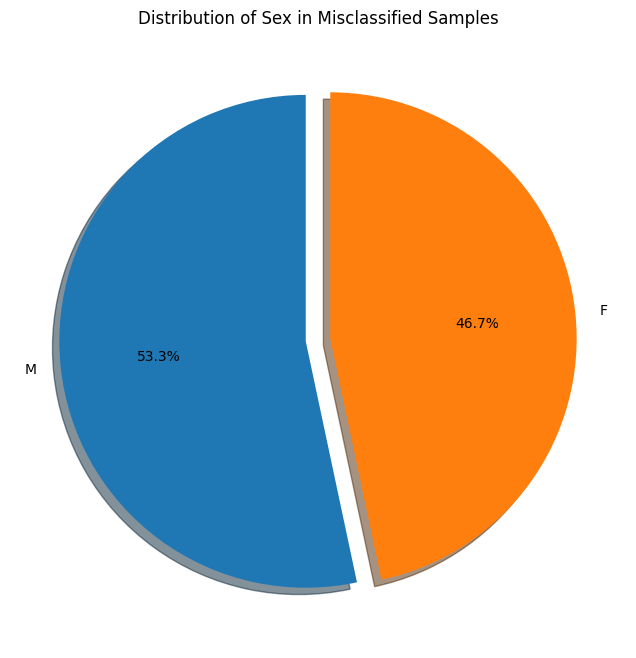

In [32]:
plot_pie_chart(misclassified_metadata_df, 'sex')

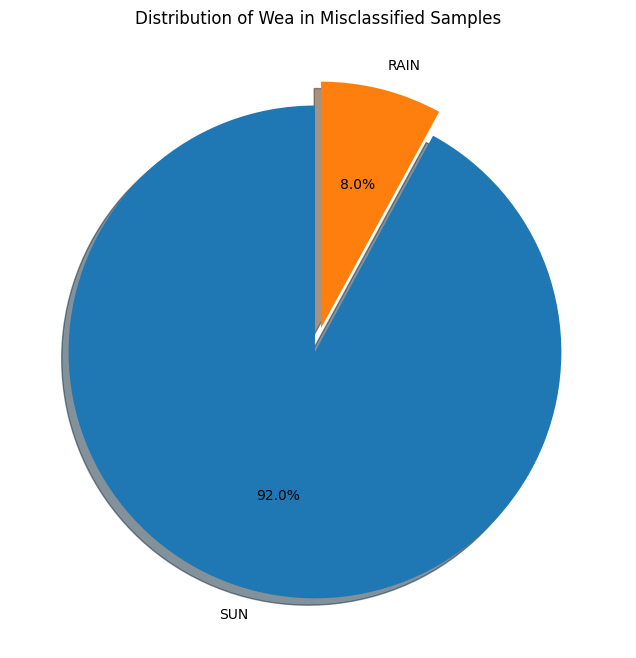

In [33]:
plot_pie_chart(misclassified_metadata_df, 'wea')

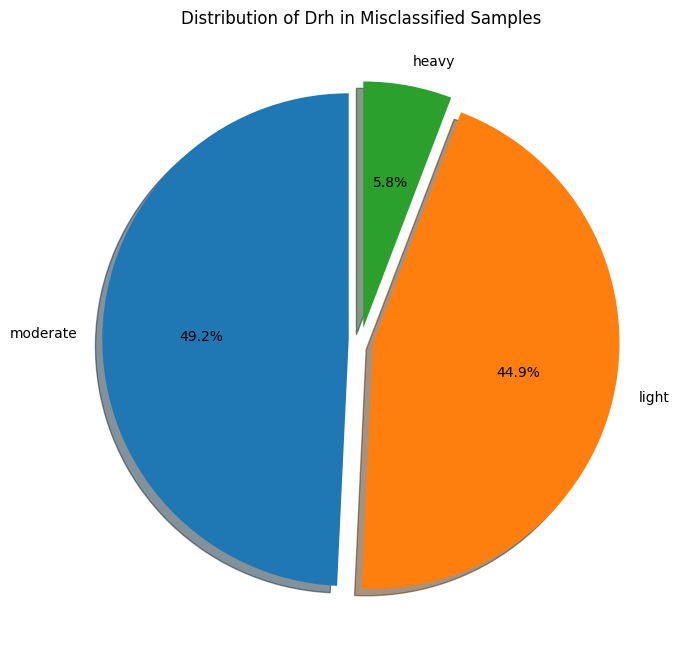

In [34]:
plot_pie_chart(misclassified_metadata_df, 'drh')

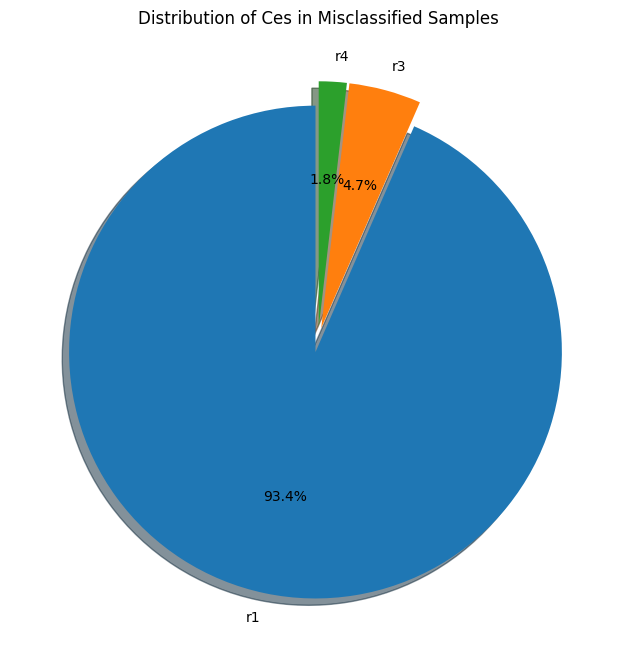

In [ ]:
plot_pie_chart(misclassified_metadata_df, 'ces')

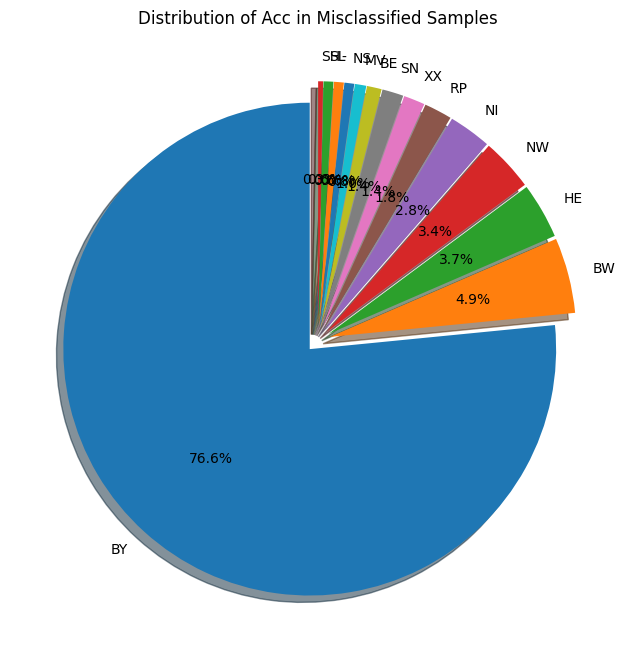

In [37]:
plot_pie_chart(misclassified_metadata_df, 'acc')

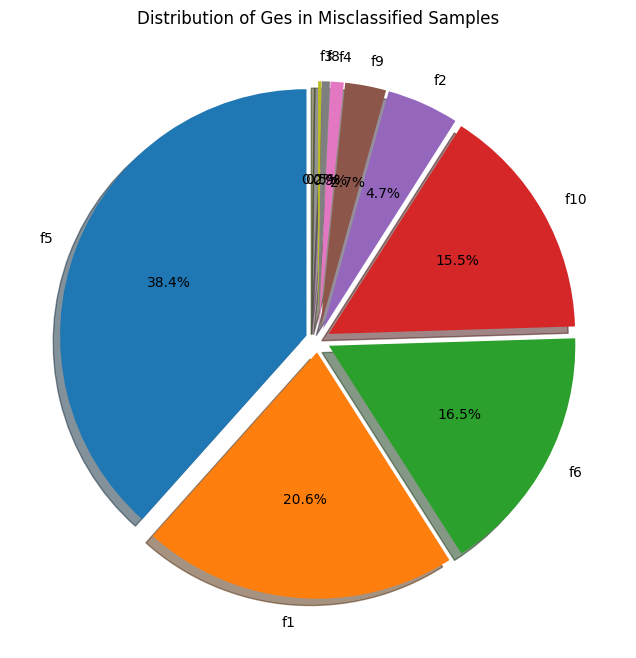

In [36]:
plot_pie_chart(misclassified_metadata_df, 'ges')